# Monte Carlo Simulation for stock market prediction

c:\users\win10vm\appdata\local\programs\python\python38-32\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


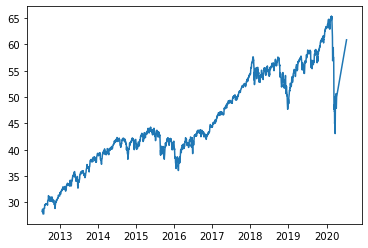

In [1]:
# Pull data from yahoo an plot it
from pandas_datareader import data as web
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


stock = 'IWDA.L' #iShares Core MSCI World UCITS ETF USD (Acc) 
years = 8 # It would be better to look back more than 8 years but sadly the yahoo data is only good 8 years back

start_date = (datetime.datetime.now() - datetime.timedelta(days=years*365)).strftime("%m-%d-%Y")
df = web.DataReader(stock, data_source='yahoo', start=start_date)

plt.plot(df['Adj Close'])

The stock prize development can be modeled using the continuous compound rate. The block [Investmentcache](https://investmentcache.com/magic-of-log-returns-concept-part-1/) neatly explains the relationship between the yearly compound return formula and the continuous compound rate.

The endprize of the stock $P_t$ can be calculated from the starting prize $P_0$ and the return $r$ over time $t$ or from the starting prize combined with the continuous compound return $R$.
$$
P_t = P_0(1+r) = P_0 e^{R}
$$

Reformulating the equation leads to
$$
R = ln(1+r) = ln\left(\frac{P_t}{P_0}\right)
$$

In [2]:
# Calculate R for t={one day} for every day
R = np.log(1 + df['Adj Close'].pct_change())

The base formula for this Monte Carlo Simulation:  
$$
P_t=P_0 e^{\text{Drift} + \text{RandomComponent}}
$$
and the following code block are taken from: [Lester Leong, towards data science](https://towardsdatascience.com/python-risk-management-monte-carlo-simulations-7d41c891cb5)

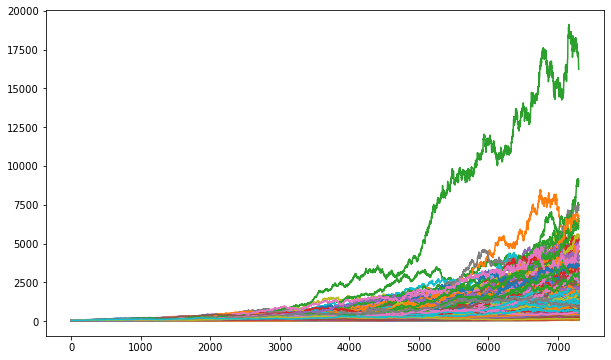

In [3]:
# Running the Monte Carlo Simulation for a 20year forecast
from scipy.stats import norm

mc_iterations = 1000  # Number of Monte Carlo iterations
years_forecast = 20   # We want to predict 20 years into the future

u = R.mean()
var = R.var()
drift = u - (0.5 * var)
stdev = R.std()

days_forecast = years_forecast*365
daily_return_factor = np.exp(drift + stdev * norm.ppf(np.random.rand(days_forecast, mc_iterations)))

future_prices = np.zeros_like(daily_return_factor)
future_prices[0] = df['Adj Close'].iloc[-1] #Takes last data point as startpoint point for simulation
for t in range(1, days_forecast):
    future_prices[t] = future_prices[t - 1] * daily_return_factor[t]

#Plot simulations
plt.figure(figsize=(10,6))
plt.plot(future_prices);


## Probabilities for different annual interest rates depending on investment duration

1 year: Mean 14.15%, Var 4.92
2 year: Mean 13.73%, Var 2.48
5 year: Mean 13.31%, Var 1.03
10 year: Mean 13.24%, Var 0.47
20 year: Mean 13.26%, Var 0.25


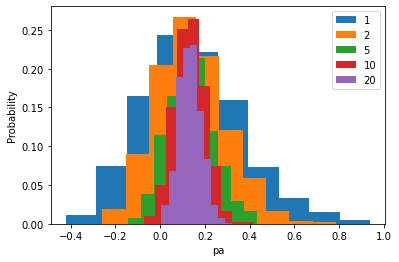

In [9]:
years = (1, 2, 5, 10, 20)
for year in years:
    pa = (future_prices[year*365-1] / future_prices[0])**(1/year) - 1 
    print(f"{year} year: Mean {pa.mean()*100:.2f}%, Var {pa.var()*100:.2f}")
    weights = np.ones_like(pa)/float(len(pa))
    n, bins, patches = plt.hist(pa, weights=weights)#, range=(-0.05, 0.3))

    plt.xlabel(f'pa')
    plt.ylabel('Probability')

plt.legend(years)